In [10]:
import numpy as np
import pandas as pd
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

In [11]:
#케라스가 내 모델에 맞추기 위해 사용할 수 있는 one-hot 벡터 배열을 one-hot 벡터 배열로 바꾸기
from keras.utils.np_utils import to_categorical
#입력이미지의 shape 이 (batch_size, width, height, n_channels)로 넣어줘야함
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)

#레이블 준비하기
y_train = to_categorical(train['digit'].values)
#print(X_train[0].shape)
#print(len(y_train))

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)
#from keras.layers import LeakyReLU


model = Sequential() #클래스 객체 생성
model.add(Conv2D(32, kernel_size = 3, input_shape = (28, 28, 1)))  #26 * 26 * 32
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, kernel_size = 3)) # 24 * 24 * 32
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu')) #12 * 12 * 32
model.add(Dropout(0.3)) 

model.add(Conv2D(64, kernel_size = 3))# 10 * 10 * 64
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size = 3)) # 8 * 8 * 64
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size = 3)) # 6 * 6 * 64
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size = 3)) # 4 * 4 * 64
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu')) # 2 * 2 * 64
model.add(Dropout(0.3)) 

model.add(Conv2D(128, kernel_size = 2)) # 1 * 1 * 128
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

In [14]:
# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)       

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [17]:
from sklearn.model_selection import train_test_split
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train, y_train, test_size = 0.1)

#fit 메서드로 트레이닝 시작
for i in range(5):
    
    hist = model.fit_generator(
        datagen.flow(X_train2, y_train2, batch_size=32),
        epochs=epochs, 
        steps_per_epoch=X_train2.shape[0]//32,
        validation_data=(X_val2, y_val2), 
        callbacks=[annealer], 
        verbose=0
    )
    print(
        f"CNN: Epochs={epochs:d}, " +
        f"Train accuracy={max(hist.history['acc']):.5f}, " +
        f"Validation accuracy={max(hist.history['val_acc']):.5f}"
    )

#CNN: Epochs=45, Train accuracy=0.89748, Validation accuracy=0.91220
#Dropout값 변형 & layer 추가

CNN: Epochs=45, Train accuracy=0.81005, Validation accuracy=0.78049
CNN: Epochs=45, Train accuracy=0.90378, Validation accuracy=0.84390
CNN: Epochs=45, Train accuracy=0.95230, Validation accuracy=0.86341
CNN: Epochs=45, Train accuracy=0.97386, Validation accuracy=0.86829
CNN: Epochs=45, Train accuracy=0.97902, Validation accuracy=0.86341


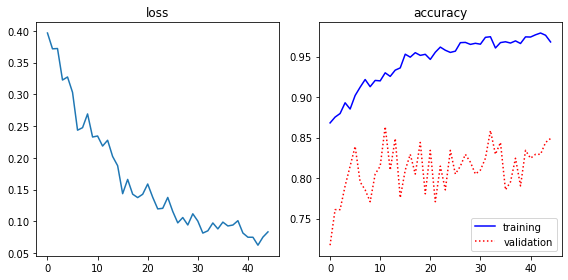

In [18]:
#성능 visualize
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"second_5times.json", "w") as json_file : 
    json_file.write(model_json)

In [20]:
# 예측 진행
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
#results = model.predict(X_test)
submission['digit']=np.argmax(model.predict(X_test),axis =1)

In [21]:
#submission.digit = results
submission.to_csv('second_5times.csv', index=False)